In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# def compute_gini(model):
#     agent_wealths = [agent.wealth for agent in model.schedule.agents]
#     x = sorted(agent_wealths)
#     N = model.num_agents
#     B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
#     return 1 + (1 / N) - 2 * B

def compute_gini(model):

    wealths = [agent.wealth for agent in model.schedule.agents]
    # Sort the wealths.
    wealths = np.sort(wealths)

    # Get the number of agents.
    n = len(wealths)

    # Get the cumulative wealth.
    cumulative_wealth = np.cumsum(wealths)

    # Calculate the Lorenz curve.
    lorenz_curve = cumulative_wealth / cumulative_wealth[-1]

    # Calculate the Gini coefficient.
    gini = 1 - 2 * np.trapz(lorenz_curve)

    return gini


class SocialAgent(Agent):
    def __init__(self, unique_id, model, initial_wealth, norm): # Norm = 0  or 1 corresponding to selfish or altruistic behavior
        super().__init__(unique_id, model)
        self.norm = norm
        self.wealth = initial_wealth

  

    def step(self):
        self.generate_wealth()
        self.expenditure()
        self.trade()
        self.wealth_transfer()
        self.social_influence()


    def generate_wealth(self):
        # Proportional wealth increase.
        self.wealth *= 1 + self.model.growth_rate

        # Fixed wealth increase which emulates a salary from a job. # This should depend on employment status.
        self.wealth += self.model.salary

    def expenditure(self):
        self.wealth -= self.model.expenditure
    
    def trade(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        # Pick a random neighbor
        neighbor = self.random.choice(neighbors)

        # Wealth transfer between agents based on trade ratio.
        trade_amount = self.model.trade_ratio * self.wealth
        self.wealth -= trade_amount
        neighbor.wealth += trade_amount

    def wealth_transfer(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        # Pick a random neighbor
        neighbor = self.random.choice(neighbors)

        # Check if norm of the agent is altruistic
        if self.norm == 1:
            # Only donate if the neighbor is poorer than the agent.
            if neighbor.wealth < self.wealth:

                # Wealth transfer between agents based on trade ratio.
                wealth_transfer = self.model.donation_ratio * self.wealth
                self.wealth -= wealth_transfer
                neighbor.wealth += wealth_transfer

                # Update behaviour of the neighbor if neighbor is selfish
                if neighbor.norm == 0: # Tit for tat
                    neighbor.norm = 1
    
    def social_influence(self): #TODO need to check
        # Change your norm if majority of your neighbors in the network are of the same norm
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return
        
        norm_counts = {}
        for neighbor in neighbors:
            if neighbor.norm in norm_counts:
                norm_counts[neighbor.norm] += 1
            else:
                norm_counts[neighbor.norm] = 1
        
        majority_norm = max(norm_counts, key=norm_counts.get)
        majority_norm_count = norm_counts[majority_norm]
        
        if majority_norm_count > len(neighbors) / 2:
            self.norm = majority_norm


class SocialNormModel(Model):
    def __init__(
            self, 
            num_agents, 
            avg_node_degree, 
            rewiring_prob, 
            initial_wealth, 
            growth_rate, 
            trade_ratio, 
            salary, 
            expenditure, 
            donation_ratio, 
            ratio_of_altruistic_agents,
            wealth_distribution="equal"

                 ):
        
        self.num_agents = num_agents
        self.growth_rate = growth_rate
        self.trade_ratio = trade_ratio
        self.salary = salary
        self.expenditure = expenditure
        self.donation_ratio = donation_ratio
        self.wealth_distribution = wealth_distribution

        # Create network
        self.G = nx.watts_strogatz_graph(n=num_agents, k=avg_node_degree, p=rewiring_prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)

        # Generate initial wealth distribution
        initial_wealths = self.generate_initial_wealth(initial_wealth)

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            # Determine if the agent is altruistic based on the given ratio
            if random.random() < ratio_of_altruistic_agents:
                norm = 1
            else:
                norm = 0

            agent = SocialAgent(unique_id=i, model=self, initial_wealth=initial_wealths[i], norm=norm)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        # Data collector (optional)
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Norm": "norm"}
        )

    def generate_initial_wealth(self, initial_wealth):
        # Equal distribution
        if self.wealth_distribution == "equal":
            return [initial_wealth] * self.num_agents

        # Unequal distribution
        elif self.wealth_distribution == "unequal":
            return sorted([random.expovariate(1) * initial_wealth for _ in range(self.num_agents)], reverse=True)

        # Very Unequal distribution
        elif self.wealth_distribution == "very_unequal":
            return sorted([random.paretovariate(1.5) * initial_wealth for _ in range(self.num_agents)], reverse=True)
        
        # Normal distribution
        elif self.wealth_distribution == "normal": 
            return [random.normalvariate(0, 1) * initial_wealth for _ in range(self.num_agents)]

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def run_model(self, n):
        for _ in range(n):
            self.step()



### Equal

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_26223/357913311.py:31: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


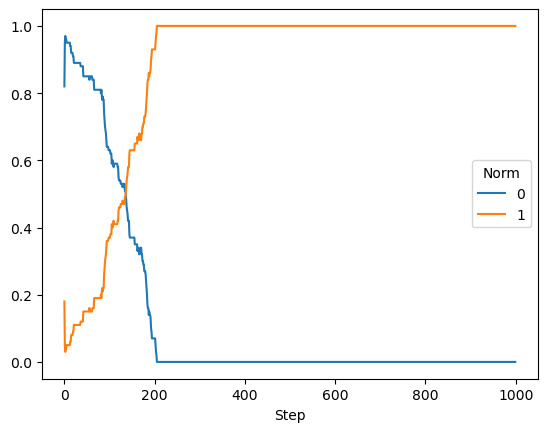

In [3]:


# Example usage
params = {
    "num_agents": 100, # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.1,
    "initial_wealth": 100, # Can be heterogenous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 1, # This can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "ratio_of_altruistic_agents": 0.2, # Main thing that we change #0.152 to 0.153
    "wealth_distribution": "equal"
}

timesteps = 1000
model = SocialNormModel(**params)
model.run_model(timesteps)

# # Data collection results
data = model.datacollector.get_agent_vars_dataframe()
# print(data)

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()
plt.show()

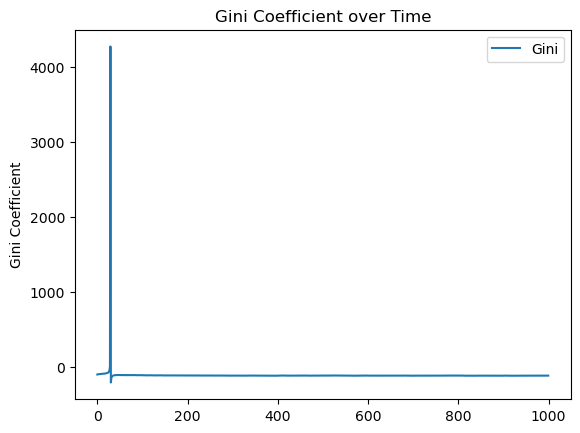

In [4]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

### Unequal

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_26223/357913311.py:31: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


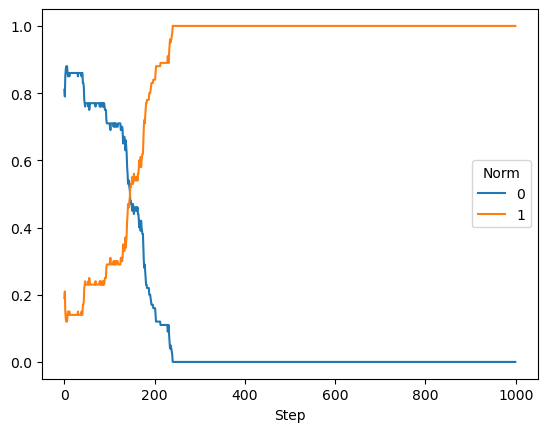

In [5]:


# Example usage
params = {
    "num_agents": 100, # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.1,
    "initial_wealth": 100, # Can be heterogenous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 1, # This can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "ratio_of_altruistic_agents": 0.2, # Main thing that we change #0.152 to 0.153
    "wealth_distribution": "unequal"
}

timesteps = 1000
model = SocialNormModel(**params)
model.run_model(timesteps)

# # Data collection results
data = model.datacollector.get_agent_vars_dataframe()
# print(data)

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()
plt.show()

#### Very Unequal

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_26223/357913311.py:31: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


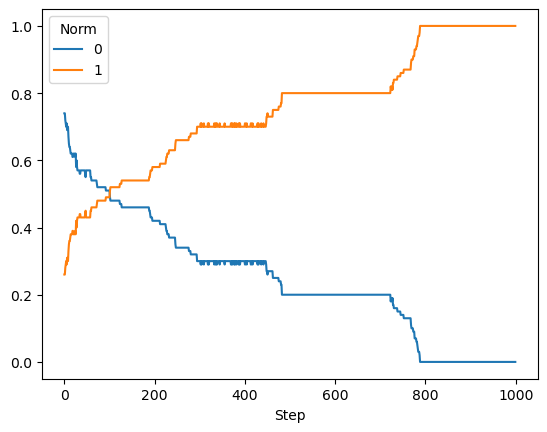

In [6]:


# Example usage
params = {
    "num_agents": 100, # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.1,
    "initial_wealth": 100, # Can be heterogenous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 1, # This can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "ratio_of_altruistic_agents": 0.2, # Main thing that we change #0.152 to 0.153
    "wealth_distribution": "very_unequal"
}

timesteps = 1000
model = SocialNormModel(**params)
model.run_model(timesteps)

# # Data collection results
data = model.datacollector.get_agent_vars_dataframe()
# print(data)

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()
plt.show()

#### Normal

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_26223/357913311.py:31: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


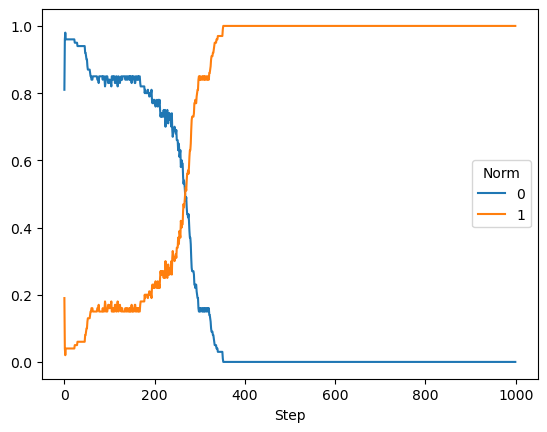

In [7]:


# Example usage
params = {
    "num_agents": 100, # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.1,
    "initial_wealth": 100, # Can be heterogenous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 1, # This can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "ratio_of_altruistic_agents": 0.2, # Main thing that we change #0.152 to 0.153
    "wealth_distribution": "normal"
}

timesteps = 1000
model = SocialNormModel(**params)
model.run_model(timesteps)

# # Data collection results
data = model.datacollector.get_agent_vars_dataframe()
# print(data)

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()
plt.show()